In [1]:
import numpy as np                        # For linear algebra
import cvxpy as cp
import matplotlib.pyplot as plt            # For plots
np.random.seed(1)                          # Generate random seed
np.set_printoptions(precision=1)           # Set nice printing format

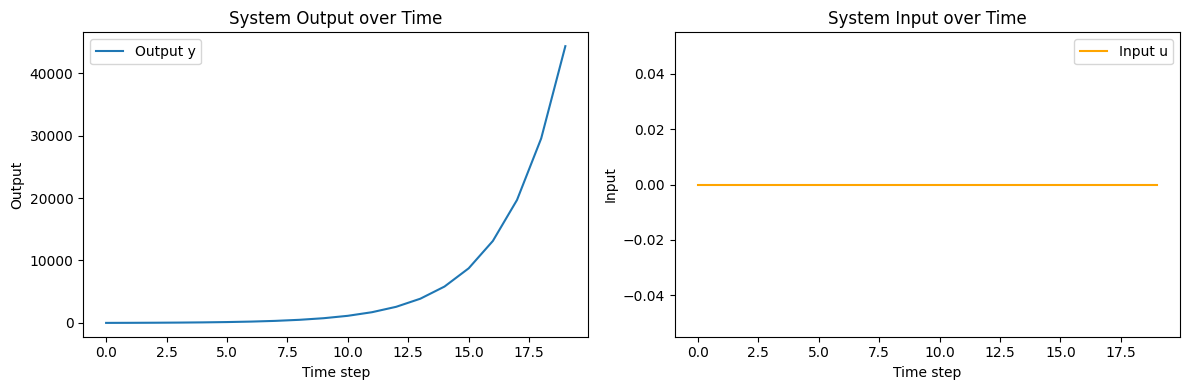

In [4]:
# System parameters dx/dt = Ax + Bu, y = Cx
A = np.array([[1, 2],
              [0, 1.5]])
B = np.array([[1],
              [3]])
C = np.array([[1, 0]])

n = A.shape[0]
m   = B.shape[1]
p   = C.shape[0]

# Initial state? example x
x0 = np.array([[6],[5]])

# parameters
T_d = 20 #total number of data points

# run a simulation to show the autonomous system response
x_sys = np.zeros((T_d+1, n))
u_sys = np.zeros((T_d, m))
y_sys = np.zeros((T_d, p))

x_sys[0] = x0.ravel()
for i in range(T_d):
    x_sys[i+1] = A@x_sys[i] + B@u_sys[i]
    y_sys[i] = C@x_sys[i]

# Build Hankel matrices
def hankel_matrix(data, rows, cols):
    H = np.zeros((rows, cols))
    for i in range(rows):
        H[i,:] = data[i:i+cols,0]
    return H

#plot data
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(T_d), y_sys, label='Output y')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title('System Output over Time')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(T_d), u_sys, label='Input u', color='orange')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.title('System Input over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# build according to paper "Formulas for Data-Driven Control: Stabilization, Optimality, and Robustness" section II
# parameters
t = 5 #response time [0, t-1] #= T_ini + T_fut
# T_d = 20 #total number of data points

# Collect data
x_data = np.zeros((T_d+1,2))
u_data = np.zeros((T_d,1))
y_data = np.zeros((T_d,1))

for i in range(T_d):
    u_data[i] = np.random.randn(1)
    x_data[i+1] = A@x_data[i] + B@u_data[i]
    y_data[i] = C@x_data[i]

H_u = hankel_matrix(u_data, t, T_d - t + 1)
H_y = hankel_matrix(y_data, t, T_d - t + 1)

# print("Hankel matrix of inputs H_u:")
# print(H_u)
# print("\nHankel matrix of outputs H_y:")
# print(H_y)

In [ ]:
#solve for a g
x = np.zeros((t+1,2))
u = np.zeros((t,1))
y = np.zeros((t,1))

for i in range(t):
    u[i] = np.random.randn(1)
    x[i+1] = A@x[i] + B@u[i]
    y[i] = C@x[i]

# solve for g
g = np.linalg.pinv(np.vstack((H_u, H_y))) @ np.vstack((u, y))
print("Solution g:")
print(g)

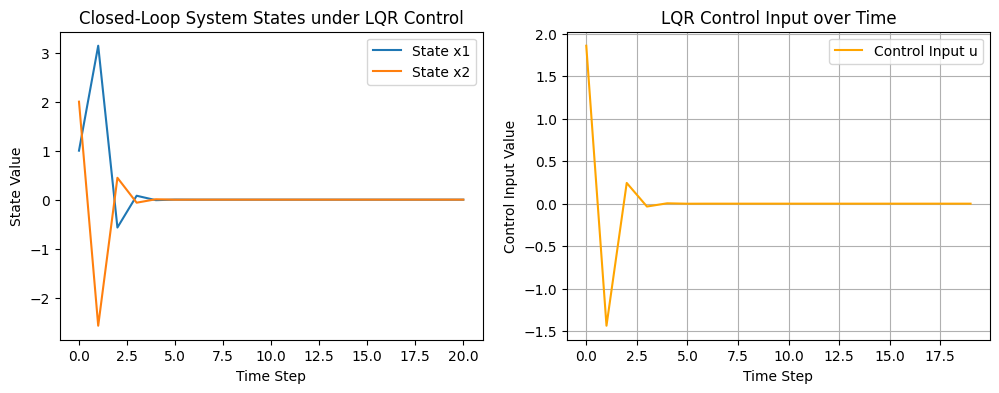

In [23]:
#LQR control
Q = np.eye(2)
Q[1,1] = 0 #get rid of x2 penalty
R = np.eye(1)*0.1

# def lqr(x, xf, Q, R, A, B, N):
#     #actual state x, desired state xf, N number of iterations
#     x_error = x - xf
#     P = np.zeros((N+1, Q.shape[0], Q.shape[1]))
#     P[N] = Q
#     for k in range(N-1, -1, -1):
#         P[k] = Q + A.T @ P[k+1] @ A - A.T @ P[k+1] @ B @ np.linalg.inv(R + B.T @ P[k+1] @ B) @ B.T @ P[k+1] @ A
#     K = np.zeros((N, R.shape[0], Q.shape[0]))
#     u = np.zeros((N, R.shape[0], 1))
#     for k in range(N):
#         K[k] = np.linalg.inv(R + B.T @ P[k+1] @ B) @ B.T @ P[k+1] @ A
#         u[k] = -K[k] @ x_error
#     return u[N-1]

def lqr(x, xf, Q, R, A, B, N):
    P = [None]*(N+1); P[N] = Q
    for k in range(N-1, -1, -1):
        S = R + B.T @ P[k+1] @ B
        Kk = np.linalg.solve(S, B.T @ P[k+1] @ A)
        P[k] = Q + A.T @ (P[k+1] - P[k+1] @ B @ np.linalg.solve(S, B.T @ P[k+1])) @ A
    # use stage-0 gain:
    S0 = R + B.T @ P[1] @ B
    K0 = np.linalg.solve(S0, B.T @ P[1] @ A)
    return -K0 @ (x - xf)


# simulate closed loop system
N = 20 #number of control steps
x_cl = np.zeros((N+1, x0.shape[0], x0.shape[1]))
x_cl[0, :, :] = [[1],[2]] #initial state
xf = np.array([[0],[0]]) #desired state
u_cl = np.zeros((N, R.shape[0], 1))
for k in range(N):
    u_control = lqr(x_cl[k], xf, Q, R, A, B, 10)
    x_cl[k+1] = A @ x_cl[k] + B @ u_control
    u_cl[k] = u_control

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_cl[:,0,0], label='State x1')
plt.plot(x_cl[:,1,0], label='State x2')
plt.title('Closed-Loop System States under LQR Control')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(N), -u_cl[:,0,0], label='Control Input u', color='orange')
plt.title('LQR Control Input over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Input Value')
plt.legend()
plt.grid()
plt.show()

Simulation complete


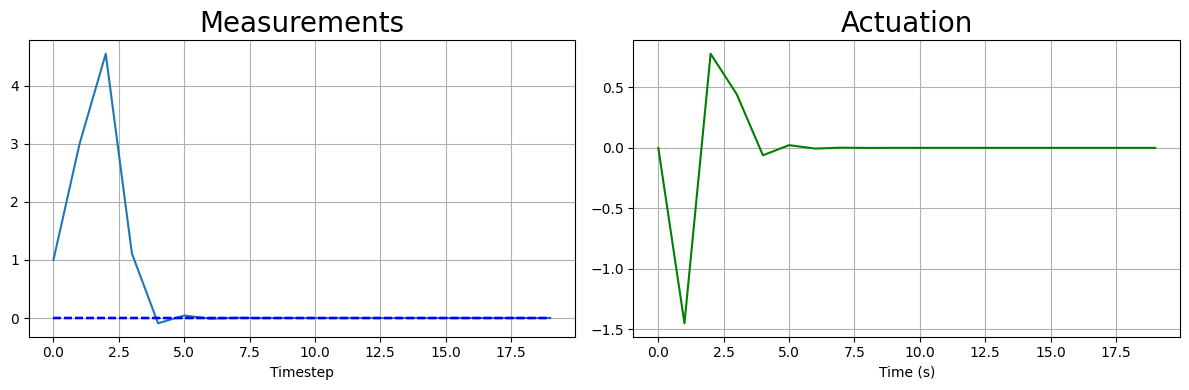

In [21]:
# DeePC

# T_ini is the number of timesteps into the past that the DeePC optimization considers.
# T_future is the number of timesteps into the future that the DeePC optimization plans for.
T_ini = 2
T_fut = 8 #randomly chosen
T = T_ini+T_fut
T_d = 30 #total number of data points

# Collect data
x_data = np.zeros((T_d+1,2))
u_data = np.zeros((T_d,1))
y_data = np.zeros((T_d,1))

for i in range(T_d):
    u_data[i] = np.random.randn(1)
    x_data[i+1] = A@x_data[i] + B@u_data[i]
    y_data[i] = C@x_data[i]

H_u = hankel_matrix(u_data, T, T_d - T + 1)
H_y = hankel_matrix(y_data, T, T_d - T + 1)

# this is input cost weight in the DeePC optimization
r = 1e-3

# regularization coefficients
lambda_ini = 1e3 # for estimation slack (choose typically large)
lambda_g = 1e-4 # for 1-norm regularizer (choose typically small)

class DeePCcontrollerClass:
    def __init__(self, T_d, T_ini, T_fut,r, H_u, H_y):

        self.T_d = T_d
        self.T_ini = T_ini
        self.T_fut = T_fut
        self.T = self.T_ini + self.T_fut

        self.r = r # input cost weight

        # offline data
        self.H_u = H_u
        self.H_y = H_y


    def step(self, u_past, y_past, y_ref):
        """
        Returns the first action of the optimal input sequence.
        """
        # set up the DeePC optimization in CVX
        # Helpful CVX functions: cp.Variable(), cp.quad_form()
        # initialize the variables
        g = cp.Variable(self.T_d - self.T +1)
        u = cp.Variable(self.T_fut)
        y = cp.Variable(self.T_fut)
        sigma = cp.Variable(self.T_ini)

        # partition the data matrix
        U_p = self.H_u[:m*T_ini]
        U_f = self.H_u[m*T_ini:]
        Y_p = self.H_y[:p*T_ini]
        Y_f = self.H_y[p*T_ini:]

        # cost function with control cost + estimation slack penalty + 1-norm regularizer
        cost = cp.quad_form(y-y_ref, np.eye(T_fut)) + self.r*cp.quad_form(u, np.eye(T_fut)) + lambda_ini*cp.quad_form(sigma,np.eye(T_ini)) + lambda_g*cp.norm(g,1)

        # set the DeePC equality constraints
        constraints = [
            U_p@g == u_past,
            U_f@g == u,
            Y_p@g == y_past+sigma,
            Y_f@g == y
        ]
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.OSQP,
    verbose=False,
    max_iter=200000,        # raise from default
    eps_abs=1e-5,
    eps_rel=1e-5,
    polish=True,
    warm_start=True)

        if prob.status != 'optimal':
            raise Exception(f'cvx had an issue with the optimization. got prob.status: {prob.status}')

        u_fut = u.value
        return u_fut

DeePCcontroller = DeePCcontrollerClass(T_d, T_ini, T_fut, r, H_u, H_y)

# DeePC evaluation simulation settings

T_sim = 20 #simulation time steps
y_reference = 0

u_sim = np.zeros((T_sim, 1))
x_sim = np.zeros((T_sim+1, n))
y_sim = np.zeros((T_sim, 1))
y_reference_sim = np.ones((T_sim, p*T_fut))*y_reference

#Initial states set to 0
x_sim[0] = np.ones(n)
u_past_sim = np.zeros(T_ini)
y_past_sim = np.zeros(T_ini)

for i in range(T_sim):
      # Get the control action using DeePCcontroller.step()
      u_fut = DeePCcontroller.step(u_past_sim, y_past_sim, y_reference_sim[i])
      u_next = u_fut[0]
      u_sim[i] = u_next

      #siulate one step
      x_sim[i+1] = A@x_sim[i] + B@u_sim[i]
      y_sim[i] = C@x_sim[i]

      # Update u_past_sim and y_past_sim

      u_past_sim = np.append(u_past_sim[1:], u_sim[i])
      y_past_sim = np.append(y_past_sim[1:], y_sim[i])

print('Simulation complete')

## Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(0,T_sim), y_sim)
plt.plot(range(0,T_sim), y_reference_sim, 'b--')
plt.xlabel('Timestep')
plt.title("Measurements", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T_sim), u_sim, 'g')
plt.xlabel('Time (s)')
plt.title("Actuation", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.show()